In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import QFT, IntegerComparator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

from lib.losstre import *
from tqdm import trange

from dQA_circuit import HammingEvolution

In [2]:
# class Heaviside_evolution:
#     """
#     Class to generate all the modules of Heaviside evolution circuit consistently.
#     """
#     def __init__(self, num_data_qubits) -> None:
        
#         # number of qubits, number ancillas used to count, number of ancillas used to compare Hamming distance
#         self.num_data_qubits = num_data_qubits
#         self.num_count_ancillas = int(np.ceil(np.log2(num_data_qubits+1)))

#         # in this situation the comparison is really simple
#         self.simple_compare = (self.num_data_qubits + 1 == 2**self.num_count_ancillas)

#         # circuit initializer
#         self.data_qubits = QuantumRegister(self.num_data_qubits)
#         self.count_ancillas = AncillaRegister(self.num_count_ancillas)
#         self.qc = QuantumCircuit(self.data_qubits, self.count_ancillas)

#         # intialize comparison ancillas if necessary
#         if not self.simple_compare:
#             self.num_comp_ancillas = self.num_count_ancillas
#             self.comp_ancillas = AncillaRegister(self.num_count_ancillas)
#             self.qc.add_register(self.comp_ancillas)

#         # ancilla in which the Heaviside control will be stored
#         if self.simple_compare:
#             self.control_ancilla = self.count_ancillas[-1]
#         else:
#             self.control_ancilla = self.comp_ancillas[0]


#     def init_state_plus(self):
#         """
#         Generate a circuit where all the qubits are initialized at |+> = H|0> intead of simply |0>.
#         """

#         # return a new copy of the circuit, but with the same number of qubits for consistency
#         circ = self.qc.copy()

#         for iq in range(self.num_data_qubits):
#             circ.h(self.data_qubits[iq])

#         return circ


#     def Hamming_count(self, train_data):
#         """ 
#         Generate circuit of `self.num_data_qubits` qubits that counts the Hamming distance from the training data.
#         The count is stored in the `self.count_ancillas` qubits. 
#             - train_data: vector of training data.

#             Conventions:
#             - (1,-1) <--> (|0>,|1>)
#             - little endians: least significant bit is the last one of the string
#         """

#         assert len(train_data) == self.num_data_qubits, "Wrong dimension of training data"

#         # return a new copy of the circuit, but with the same number of qubits for consistency
#         circ = self.qc.copy()


#         # flip only when the training data is -1: in this way the circuit can simply count the number 
#         # of states that are |1>
#         # little endians convention is applied !!! train_data[::-1] !!!
#         for iq, train_data_i in enumerate(train_data[::-1]):
#             if train_data_i == -1:
#                 circ.x(self.data_qubits[iq])

#         # initial Hadamards to create superposition in the counter register
#         for ia in range(self.num_count_ancillas):
#             circ.h(self.count_ancillas[ia])
        
        
#         # Phase estimation
#         for ia in range(self.num_count_ancillas):
#             # the order is from the lowest index of the ancilla to the highest
#             n_reps = 2**ia

#             # repeat n_reps times the application of the unitary gate controlled on the ancillary qubit
#             for rep_idx in range(n_reps):
#                 for iq in range(self.num_data_qubits):
#                     circ.cp(2*np.pi/2**self.num_count_ancillas, self.count_ancillas[ia], self.data_qubits[iq])


#         # invert flip applied previously to count the number of |1>
#         # little endians convention is applied !!! train_data[::-1] !!!
#         for iq, train_data_i in enumerate(train_data[::-1]):
#             if train_data_i == -1:
#                 circ.x(self.data_qubits[iq])

#         circ.barrier()
#         qft_circ = QFT(self.num_count_ancillas, inverse=True).decompose(reps=1)

#         circ = circ.compose(qft_circ, self.count_ancillas)

#         # add an additional comparison circuit if needed
#         if not self.simple_compare:
#             circ = circ.compose(IntegerComparator(self.num_count_ancillas, int(np.ceil(self.num_data_qubits/2.0)), geq=True).decompose(reps=1),
#                                 qubits=list(self.count_ancillas)+list(self.comp_ancillas))

#         return circ


#     def U_z(self, train_data, gamma):
#         """
#         Generate circuit for Uz evolution according to the training data and the value of gamma.
#             - train_data: vector of training data.
#             - gamma: multiplicative float in the time evolution definition.

#             Conventions:
#             - (1,-1) <--> (|0>,|1>)
#             - little endians: least significant bit is the last one of the string
#         """
#         assert len(train_data) == self.num_data_qubits, "Wrong dimension of training data"

#         # return a new copy of the circuit, but with the same number of qubits for consistency
#         circ = self.qc.copy()
#         circ.barrier()

#         # define controlled operation on the 'ancilla_index'
#         # little endians convention is applied !!! iq and idata goes on opposite directions !!!
#         for iq, idata in zip(range(self.num_data_qubits),range(len(train_data)-1,-1,-1)):
#             circ.crz(-2*gamma*train_data[idata]/np.sqrt(self.num_data_qubits), self.control_ancilla, self.data_qubits[iq])

#         circ.barrier()
#         return circ


#     def U_x(self, beta):
#         """
#         Generate circuit for Ux evolution according to the value of beta.
#             - beta: multiplicative float in the time evolution definition.

#         """

#         # return a new copy of the circuit, but with the same number of qubits for consistency
#         circ = self.qc.copy()
#         circ.barrier()

#         for iq in range(self.num_data_qubits):
#             circ.rx(-2*beta, self.data_qubits[iq])

#         return circ

In [4]:
N_xi, N_features = 1, 7
#N_xi, N_features =  8, 10

x = np.random.randint(2, size=(N_xi, N_features))
x[ x == 0 ] = -1  # data is encoded as +- 1

csi_patterns = x#np.array([1,1,1,1,1]).reshape(1,-1)



N_csi, N = csi_patterns.shape
labels = np.ones((N_csi, ))

In [5]:
print(csi_patterns)

[[1 1 1 1 1 1 1]]


### evolution test

In [6]:
# circuit generator
qc_generator = HammingEvolution(num_data_qubits=N)

# actual circuit (in initial superposition)
qc = qc_generator.init_state_plus()

mystates = []
mystates.append( get_statevec(qc, N) )

In [7]:
qc_generator.num_comp_ancillas

0

In [8]:
P = 50
dt = 1

for pp in trange(P):
    s_p = (pp+1)/P
    gamma_p = s_p*dt
    beta_p = (1-s_p)*dt

    for mu in range( N_csi ):
    
        # create Hamming error counter circuit based on the given pattern
        qc_counter = qc_generator.Hamming_count(train_data=csi_patterns[mu,:])
        qc_counter_inverse = qc_counter.inverse()
    
        # create evolution circuit
        qc_Uz = qc_generator.U_z(train_data=csi_patterns[mu,:], gamma=gamma_p)
    
        qc = qc.compose(qc_counter)
        qc = qc.compose(qc_Uz)
        qc = qc.compose(qc_counter_inverse)

    # measure loss
    mystates.append( get_statevec(qc, N) )

    # apply Ux
    qc_Ux = qc_generator.U_x(beta_p)
    qc = qc.compose(qc_Ux)

100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


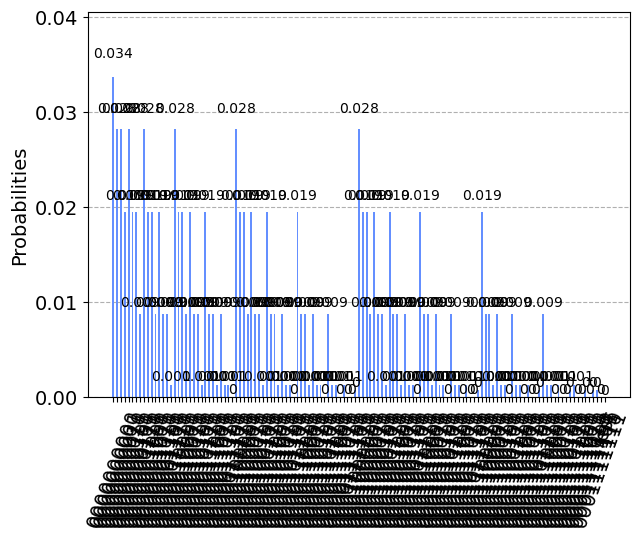

In [9]:
finalstate = Statevector.from_instruction(qc)
#finalstate.probabilities_dict()
plot_histogram(finalstate.probabilities_dict(), number_to_keep=2**N)

In [10]:
loss = np.real_if_close(get_losses_from_sts(mystates, csi_patterns, labels, representation='same'))
print(loss)

Constructing H_perc: 100%|██████████| 1/1 [00:00<00:00, 52.70it/s]

[0.05905695 0.05905695 0.05801775 0.05747163 0.05772411 0.05654648
 0.05540666 0.05567833 0.0545855  0.05327139 0.05247529 0.05232877
 0.05092742 0.04977498 0.04956187 0.05001539 0.04972065 0.04950912
 0.04858806 0.04652261 0.04251712 0.04038663 0.04173183 0.04239718
 0.03823608 0.03483149 0.03780652 0.03627268 0.03171526 0.0333492
 0.03004461 0.02867367 0.02533753 0.02454855 0.02513236 0.02425172
 0.02234181 0.02024783 0.01710271 0.01531881 0.01451082 0.0134495
 0.0109021  0.01053462 0.01030859 0.00708047 0.00482516 0.004524
 0.00459397 0.00438019 0.00403272]


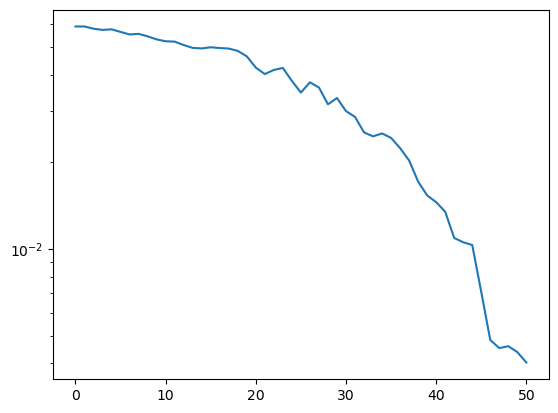

In [11]:
import matplotlib.pyplot as plt 
plt.plot(loss)
plt.yscale('log')